# Neuronal Network Dynamics Tutorial Part 2: The Wilson-Cowan Model


## Objectives
Much of computational neurocience is concerned with the question of understanding the dynamics of the activity of groups of interacting neurons. Today, we want to go through models of excitatory and inihibitory neurons and see how we can understand the dynamics of such populations. In this notebook we will introduce the **Wilson-Cowan** rate model, one of the easiest way of modelling both neuronal populations, and use it to learn more about 

- Why the system can have mutiple steady states, i.e., with proper parameters the activities will converge to different values when using different intial values

- Why the system can reach a oscillatory state.

We will introduce **phase plane** analysis to help understand these phenomena. In the phase plane, the intersection of the **nullclines** will give you the **fixed point** which is related to each steady state. We will show that after lienarize the system around the fixed point, one can conpute its corresponding **Jacobian matrix**, of which the eigenvalues can tell you how many steady states the system has, and whether the system can reach an oscillatory sate.


** Background paper:** 
* _Wilson H and Cowan J (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophysical Journal 12._

Please execute the cell below to initialize the notebook environment.

In [1]:
#@title  Setup

import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy.optimize as opt       # import root-finding algorithm
import ipywidgets as widgets       # interactive display

fig_w, fig_h = 8, 4.5 
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

## Wilson-Cowan model of exicitatory and inhibitory population

In our brain, the rich dynamics of the nuronal activities are generated by the interaction of excitatory and inhibitory subtype neurons. Thus, we continue to investigate the WC model of two coupled populations of E and I neurons in the followig sections. 

\begin{align}
\tau_E \frac{dE}{dt} &= -E + F(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a,\theta)\\
\tau_I \frac{dI}{dt} &= -I + F(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a,\theta)    \qquad (1)
\end{align}

$E(t)$ represents the average activation of the excitatory population, and $I(t)$ the activation of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of each population. The connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). 


To start, execute the cell below to initialize the simulation parameters.

In [2]:
#@title Default parameters for E/I WC model and helper function

def default_pars( **kwargs):
    pars = {}
    
    ### Excitatory parameters ###
    pars['tau_E']   = 1.   # Timescale of the E population [ms]
    pars['a_E']     = 1.2   # Gain of the E population
    pars['theta_E'] = 2.8   # Threshold of the E population

    ### Inhibitory parameters ###
    pars['tau_I']   = 2.0   # Timescale of the I population [ms]
    pars['a_I']     = 1.0   # Gain of the I population
    pars['theta_I'] = 4.0   # Threshold of the I population

    ### Connection strength ###
    pars['wEE'] = 9. # E to E
    pars['wEI'] = 4.  # I to E
    pars['wIE'] = 13. # E to I
    pars['wII'] = 11. # I to I
    
    ### External input ###
    pars['I_ext_E']  = 0.
    pars['I_ext_I']  = 0.
    
    ### simulation parameters ###
    pars['T'] = 50. # Total duration of simulation [ms]
    pars['dt'] = .1  # Simulation time step [ms]
    pars['E_init'] = 0.2 # Initial value of E
    pars['I_init'] = 0.2 # Initial value of I
    
    ### External parameters if any ###
    for k in kwargs:
        pars[k] = kwargs[k]
        
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
          
    return pars

#to remove solution
def F(x,a,theta): 
    '''
    Population activation function.

    Expecxts:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    the population activation response F(x) for input x
    '''
    # add the expression of f = F(x)
    f = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1

    return f

def my_test_plot(t, E1, I1, E2, I2):
  
    ax = plt.subplot(2,1,1)
    ax.plot(pars['range_t'], E1, 'b', label='E population')
    ax.plot(pars['range_t'], I1, 'r', label='I population')
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('Activity')
    ax.legend(loc='best')

    ax = plt.subplot(2,1,2)
    ax.plot(pars['range_t'], E2, 'b', label='E population')
    ax.plot(pars['range_t'], I2, 'r', label='I population')
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('Activity')
    ax.legend(loc='best')

    plt.tight_layout()


def my_plot_nullcline(pars):
    E_grid = np.linspace(-0.01,0.96,100)
    E_nullcline = get_E_nullcline(pars, E_grid)# calculate E nullclines
    I_grid = np.linspace(-.01,0.8,100)
    I_nullcline = get_I_nullcline(pars, I_grid)# calculate I nullclines

    plt.plot(E_grid, E_nullcline, 'b', label='E nullcline')
    plt.plot(I_nullcline, I_grid, 'r', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best',fontsize=12)

def my_plot_vector(pars, n_skip=2., scale=5):
    EI_grid = np.linspace(0., 1., 20)
    E_meshgrid, I_meshgrid = np.meshgrid(EI_grid,EI_grid)
    dEdt, dIdt = EIderivs(E_meshgrid, I_meshgrid, pars)

    n_skip = 2
    plt.quiver(E_meshgrid[::n_skip,::n_skip], I_meshgrid[::n_skip,::n_skip], 
              dEdt[::n_skip,::n_skip], dIdt[::n_skip,::n_skip], 
              angles='xy', scale_units='xy', scale=5,facecolor='c')
    
    plt.xlabel('E')
    plt.ylabel('I')



def my_plot_trajectory(pars, mycolor, x_init, mylabel):
      pars['E_init'], pars['I_init'] = x_init[0], x_init[1]
      E_tj, I_tj= simulate_wc(pars)
      plt.plot(E_tj, I_tj, color=mycolor, label=mylabel)
      plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)

      plt.xlabel('E')
      plt.ylabel('I')

def my_plot_trajectories(pars, dx, n, mylabel):
    '''
    Solve for I along the E_grid from dE/dt = 0.
   
    Expects:
    pars    : Parameter dictionary
    dx      : increment of initial values
    n       : n*n trjectories
    mylabel : label for legend
    
    Returns:
    plot of trajectory
    '''

    for ie in range(n):          
      for ii in range(n):
        pars['E_init'], pars['I_init'] = dx*ie, dx*ii
        E_tj, I_tj= simulate_wc(pars)
        if (ie==n-1)&(ii==n-1):
            plt.plot(E_tj, I_tj, 'k', alpha=0.3, label=mylabel)
        else:
            plt.plot(E_tj, I_tj, 'k', alpha=0.3)

    plt.xlabel('E')
    plt.ylabel('I')

def check_fp(x_fp):

    dEdt, dIdt = EIderivs(x_fp[0], x_fp[1], pars)

    return dEdt**2 + dIdt**2<1e-6

def plot_fp(x_fp, mycolor):
    plt.plot(x_fp_2[0], x_fp_2[1], 'o', color=mycolor, ms=8)


def dF(x,a,theta): 
    '''
    Population activation function.

    Expecxts:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    the population activation response F(x) for input x
    '''

    dFdx = a*np.exp(-a*(x-theta))*(1+np.exp(-a*(x-theta)))**-2

    return dFdx

## Just like the previous tutorial: plot out the f-I curves for the E and I populations 

Let's first plot out the f-I curves for the E and I populations by the function the defined above with the default values

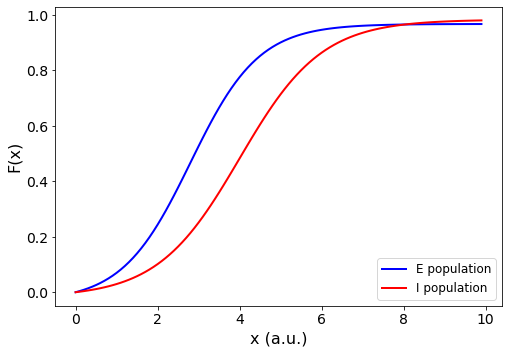

In [4]:
pars = default_pars()

x = np.arange(0,10,.1)

fig1 = plt.figure(figsize=(8, 5.5))
plt.plot(x,F(x,pars['a_E'],pars['theta_E']), 'b', label='E population')
plt.plot(x,F(x,pars['a_I'],pars['theta_I']), 'r', label='I population')
plt.legend(loc='lower right')
plt.xlabel('x (a.u.)')
plt.ylabel('F(x)')
plt.show()

## Simulation scheme

Similarly, the Euler scheme of Equation. (4) on the time-grid of of stepsize $\Delta t$ is

\begin{align}
E[k+1] &= E[k] + \frac{\Delta t}{\tau_E}[-E[k] + F(w_{EE}E[k] -w_{EI}I[k] + I^{\text{ext}}_E[k];a_E,\theta_E)]\\
I[k+1] &= I[k] + \frac{\Delta t}{\tau_I}[-I[k] + F(w_{IE}E[k] -w_{II}I[k] + I^{\text{ext}}_I[k];a_I,\theta_I)] 
\end{align}

### Compute $\Delta E$ and $\Delta I$

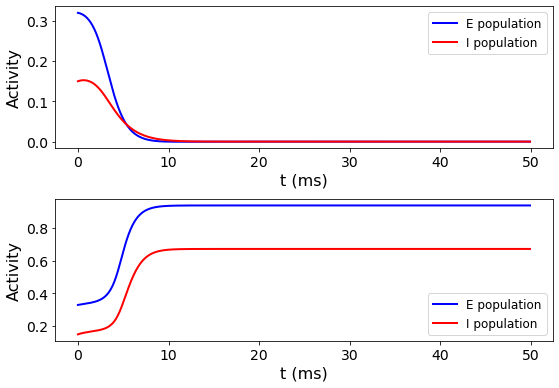

In [6]:
def simulate_wc(pars):
    
    '''
    Simulate the Wilson-Cowan equations 
    
    Expects:
    pars : Parameter dictionary
    
    Returns:
    E : Activity of excitatory population (array)
    I : Activity of inhibitory population (array)
    '''
    
    # Set parameters
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
    wEE, wEI = pars['wEE'], pars['wEI'] 
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
    E_init, I_init = pars['E_init'], pars['I_init']       
    dt, range_t = pars['dt'], pars['range_t'] 
    Lt = range_t.size 
        
    # Initialize activity
    E = np.zeros(Lt)
    I = np.zeros(Lt)
    E[0] = E_init
    I[0] = I_init
    I_ext_E = I_ext_E * np.ones(Lt)
    I_ext_I = I_ext_I * np.ones(Lt)

    # simulate the Wilson-Cowan equations 
    for k in range(Lt-1):
        dE = dt/tau_E * (-E[k] + F(wEE*E[k]-wEI*I[k]+I_ext_E[k],a_E,theta_E))
        dI = dt/tau_I * (-I[k] + F(wIE*E[k]-wII*I[k]+I_ext_I[k],a_I,theta_I))
        E[k+1] = E[k] + dE
        I[k+1] = I[k] + dI
    return E,I

pars = default_pars()
pars['E_init'], pars['I_init'] = 0.32, 0.15
E1,I1 = simulate_wc(pars)
pars['E_init'], pars['I_init'] = 0.33, 0.15
E2,I2 = simulate_wc(pars)

fig2 = plt.figure(figsize=(8, 5.5))
my_test_plot(pars['range_t'], E1, I1, E2, I2)
plt.show()

In [9]:
#@title Trajectory with different intial values
def plot_EI_diffinitial(E_init = 0.0, I_init = 0.1):

    pars = default_pars()
    pars['E_init'] = E_init
    pars['I_init'] = I_init
    E, I = simulate_wc(pars)
    
    
    plt.figure(figsize=(8, 5.5))
    plt.plot(pars['range_t'], E, 'b', label='E population')
    plt.plot(pars['range_t'], I, 'r', label='I population')
    plt.xlabel('t (ms)', fontsize=14)
    plt.ylabel('Activity', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

_ = widgets.interact(plot_EI_diffinitial, E_init = (0.30, 0.85, .01),I_init = (0.30, 0.35, .01))   

interactive(children=(FloatSlider(value=0.3, description='E_init', max=0.85, min=0.3, step=0.01), FloatSlider(…

### Think and try to answer
It is observed that the steady states of the neuronal response can be different when the initial states are chosen to be different. Why is that? What can you infer about the fixed-points of this system? How many fixed-points are there?

If you find this confusing, the answer will soon follow.

## Phase plane analysis

We next introduce the phase plane analysis to understand the behavior of the E and I populations in the Wilson-Cowan model. Different from illustrating the activities as two lines in the `Activity-t` plane $\big{(}\text{i.e. }(t, E(t))$ and $(t, I(t))\big{)}$, the phase plane shows the activities in the `I-E` plane $\big{(}\text{i.e. }(I(t), E(t)) \big{)} \text{ at any give }t$. That is each line in the phase plane indicates how $E$ and $I$ evolve with time.

### From `Activity-t` plane to `I-E` phase plane

Please complete the `plot_activity_phase` function below by adding `plt.plot()` the `Activity-time` curves and the line of `(E, I)`.
You can change the initial value of E and I activity in the second line of the following cell. Try out different values.

In [10]:
pars = default_pars(T=10)
pars['E_init'], pars['I_init'] = 0.8, 0.2
E,I = simulate_wc(pars)

def plot_activity_phase(n_t):
    plt.figure(figsize=(8, 5.5))
    plt.subplot(2,1,1)
    plt.plot(pars['range_t'], E, 'b', label='E')
    plt.plot(pars['range_t'], I, 'r', label='I')
    plt.plot(pars['range_t'][n_t], E[n_t], 'bo')
    plt.plot(pars['range_t'][n_t], I[n_t], 'ro')
    plt.axvline(pars['range_t'][n_t], 0, 1, color='k', ls='--')
    plt.xlabel('t (ms)', fontsize=14)
    plt.ylabel('Activity', fontsize=14)
    plt.legend(loc='best', fontsize=14)

    plt.subplot(2,1,2)
    plt.plot(E, I, 'k')
    plt.plot(E[n_t], I[n_t], 'ko')
    plt.xlabel('E', fontsize=18, color='b')
    plt.ylabel('I', fontsize=18, color='r')

    plt.tight_layout()
    plt.show()

_ = widgets.interact(plot_activity_phase, n_t = (0, len(pars['range_t']-1), 1))  

interactive(children=(IntSlider(value=50, description='n_t'), Output()), _dom_classes=('widget-interact',))

An important concept in the phase plane analysis is "nullcline", which will be introduced below.

### Nullclines of the Wilson-Cowan Equations

The E and I nullclines of Equation. (1) are defined as $\displaystyle{\frac{dE}{dt}}=0$ and $\displaystyle\frac{dI}{dt}=0$, that is,

\begin{align}
-E + F(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a,\theta) &= 0  \qquad (2)\\[1mm]
-I + F(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a,\theta) &= 0    \qquad (3)
\end{align}

\\

Note that, when given $\text{E}_{\text{grid}}$, one can obtain
\begin{align}
I = \frac{1}{w_{EI}}\big{[}w_{EE}E_{grid} - F^{-1}(E_{grid}; a,\theta) + I^{\text{ext}}_E \big{]} \qquad (4)
\end{align}
Then the E nullcline can be represented as $(E_{grid}, I)$ \\


Similarly, the E nullcline is $(E, I_{grid})$ where
\begin{align}
E = \frac{1}{w_{IE}} \big{[} w_{II}I_{grid} + F^{-1}(I_{grid};a,\theta) - I^{\text{ext}}_I \big{]}.  \qquad (5)  
\end{align}

\\

#### Compute the nullclines

Note that, when computing the nullclines with Equations. (9)-(10), we need to compute the inverse of F(x) first.

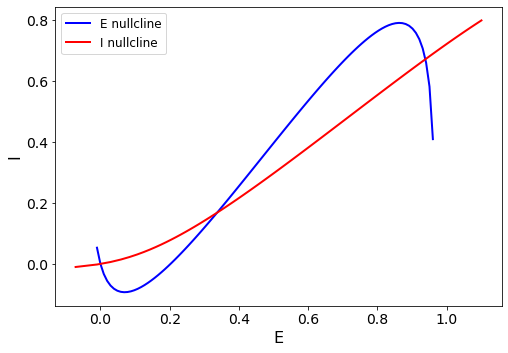

In [11]:
# Define the inverse of F
def F_inv(x,a,theta): 
    '''
    Expecxts:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
    
    Returns:
    value of the inverse function
    '''
    
    F_inverse = -1/a * np.log((x+(1+np.exp(a*theta))**-1)**-1 -1) + theta

    return F_inverse


# get the nullcline for E, solve Equation. (4) along the E-grid
def get_E_nullcline(pars, E_grid):
    '''
    Solve for I along the E_grid from dE/dt = 0.
   
    Expects:
    pars   : Parameter dictionary
    E_grid : a single value or an array
    
    Returns:
    values of I along the nullcline on the E-grid
    '''
    
    a_E, theta_E = pars['a_E'], pars['theta_E']
    wEE, wEI = pars['wEE'], pars['wEI'] 
    I_ext_E = pars['I_ext_E']
    
    I = 1./wEI * (wEE*E_grid - F_inv(E_grid, a_E, theta_E) + I_ext_E)

    return I

# get the nullcline for I, solve Equation. (5) along the I-grid
def get_I_nullcline(pars, I_grid):
    '''
    Solve for E along the I_grid from dI/dt = 0.
   
    Expects:
    pars   : Parameter dictionary
    I_grid : a single value or an array
    
    Returns:
    values of E along the nullcline on the I-grid
    '''
    
    a_I, theta_I = pars['a_I'], pars['theta_I']
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_I =  pars['I_ext_I']

    E = 1./wIE * (wII*I_grid + F_inv(I_grid, a_I, theta_I) - I_ext_I)
    
    return E

pars = default_pars() # get parameters

fig3 = plt.figure(figsize=(8, 5.5))
my_plot_nullcline(pars)

### Think
* What can we infer about the activity of the two population network from the shape and the cross-section of the two nullclines?
* How will the shape and fixed-points will change if we change W_EI and W_IE?
* How does this nullcline plot relate to the nullline of the excitatory poulation we encountered in the previous tutorial?




## <font size=6, color='red'>**Optional:**</font> Vector field

How can the phase plane and the nullcline curves help us understand the behavior of the E and I populations? Note that, the responses of the E and I populations $E(t)$ and $I(t)$ at each time point $t$ correspond to a single point in the phase plane with coordinates $(E(t),I(t))$. Therefore, the time-dependent response trajectory can be described as a contineous curve in the phase plane, and the tangent vector of the curve $(\displaystyle{\frac{dE(t)}{dt},\frac{dI(t)}{dt}})$ describes towards which direction and how fast the response changes. Therefore, as long as we can figure out the trajectory of the E and I population response in the phase plane, we can understand the behavior of the E and I populations as time evolves. Again, the determination of the trajectory curve relies on the initial state $(E(0),I(0))$ (where to start) and the tangent vector $(\displaystyle{\frac{dE(t)}{dt},\frac{dI(t)}{dt}})$ (where to go next).

##### Compute $\displaystyle{\Big{(}\frac{dE}{dt}, \frac{dI}{dt} \Big{)}}$

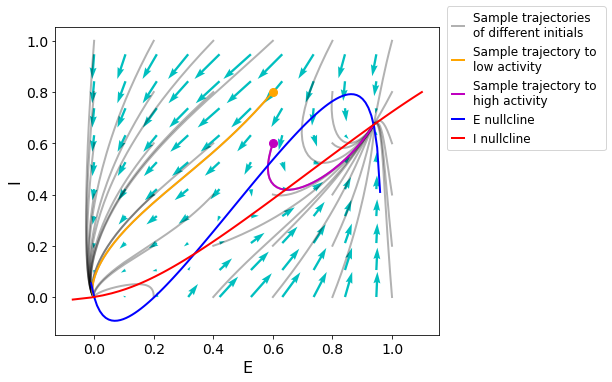

In [12]:
def EIderivs(E_grid, I_grid, pars):
    '''
    Time derivatives for E/I variables (dE/dt, dI/dt).
    '''
    
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
    wEE, wEI = pars['wEE'], pars['wEI'] 
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
    
    # complete the code according Equations. (4)
    dEdt=(-E_grid + F(wEE*E_grid-wEI*I_grid+I_ext_E,a_E,theta_E))/tau_E
    dIdt=(-I_grid + F(wIE*E_grid-wII*I_grid+I_ext_I,a_I,theta_I))/tau_I
    
    return dEdt, dIdt

pars = default_pars()

fig4 = plt.figure(figsize=(8/0.9, 5.5/0.9))
ax = fig4.add_axes([0.1, 0.1, 0.6, 0.7])
my_plot_trajectories(pars, 0.2, 6, 'Sample trajectories \nof different initials')
my_plot_trajectory(pars, 'orange', [0.6, 0.8], 'Sample trajectory to \nlow activity')
my_plot_trajectory(pars, 'm', [0.6, 0.6], 'Sample trajectory to \nhigh activity')
my_plot_vector(pars)
my_plot_nullcline(pars)
plt.legend(loc=[1.02, 0.6], fontsize=12, handlelength=1)

### Think and try to answer
It is observed that different trajectories eventually go to two points along the vector arrow direction, depending on the initial state of the E and I populations. The length of each vector shows the field strength (the rate of change). Note that the two points are the intersection of the two nullcline curves. 

However, there are in total three intersection points, but the third one is not the final state of any trajectories. Why is that? 

### Fixed Point of the E/I system

Here, the intersection points of the two nullcline curves are the fixed point of Equation. (1). Appearantly there are three fixed points of the Wilson-Cowan model with default parameters, and they have different properties, i.e., two of which will be final state of all trajectories while the third one will not. Below we will explain why. Let's first identify the coordinates of the three fixed points by executing the cell below.

In [13]:
def my_fp(pars, E_init, I_init):
    '''
    use opt.root function to solve Equations. (4)-(5) from an initial [E_init, I_init]
    '''
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
    wEE, wEI = pars['wEE'], pars['wEI'] 
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
    
    # define the right hand of wilson-cowan equations
    def my_WCr(x):
        
        E = x[0]
        I = x[1]
        
        dEdt=(-E + F(wEE*E-wEI*I+I_ext_E,a_E,theta_E))/tau_E
        dIdt=(-I + F(wIE*E-wII*I+I_ext_I,a_I,theta_I))/tau_I
        y = np.array([dEdt, dIdt])
        
        return y
    
    x0 = np.array([E_init, I_init])
    x_fp = opt.root(my_WCr, x0).x
    
    return x_fp

#### Finding the fixed points 

From the above nullclines, we can see that there are three fixed points in the case of the default paramters. You need to choose proper initial value for `opt.root` function to find the correct fixed point.

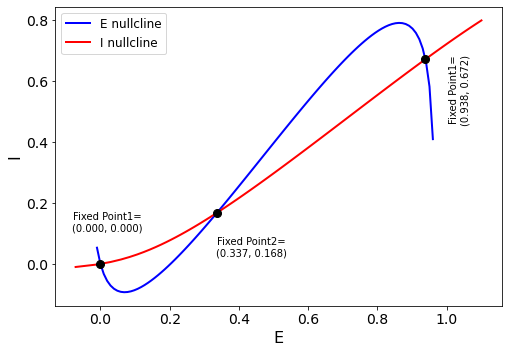

In [14]:
pars = default_pars()
x_fp_1 = my_fp(pars, 0.1, 0.1)
x_fp_2 = my_fp(pars, 0.3, 0.3)
x_fp_3 = my_fp(pars, 0.8, 0.6)

#print ('Fixed Point1 = (%.3f, %.3f)' %(x_fp_1[0], x_fp_1[1]))
#print ('Fixed Point2 = (%.3f, %.3f)' %(x_fp_2[0], x_fp_2[1]))
#print ('Fixed Point3 = (%.3f, %.3f)' %(x_fp_3[0], x_fp_3[1]))


  
fig5 = plt.figure(figsize=(8, 5.5))
my_plot_nullcline(pars)

plt.plot(x_fp_1[0], x_fp_1[1], 'ko')
plt.text(x_fp_1[0]+0.02, x_fp_1[1]+0.1, 'Fixed Point1=\n(%.3f, %.3f)' \
            %(x_fp_1[0], x_fp_1[1]), horizontalalignment='center', \
            verticalalignment='bottom')

plt.plot(x_fp_2[0], x_fp_2[1], 'ko')
plt.text(x_fp_2[0]+0.1, x_fp_2[1]-0.15, 'Fixed Point2=\n(%.3f, %.3f)' \
            %(x_fp_2[0], x_fp_2[1]), horizontalalignment='center', \
            verticalalignment='bottom')

plt.plot(x_fp_3[0], x_fp_3[1], 'ko')
plt.text(x_fp_3[0]+0.1, x_fp_3[1]-0.1, 'Fixed Point1=\n(%.3f, %.3f)' \
            %(x_fp_3[0], x_fp_3[1]), horizontalalignment='center', \
            verticalalignment='center', rotation=90)

plt.xlabel('E')
plt.ylabel('I')
plt.legend(loc='best')

plt.show()

### Stability of a fixed point and eigenvalue of the Jacobian Matrix

First, let's first rewrite Equation. (1) as following

\begin{align}
&\frac{dE}{dt} = G_E(E,I)\\[0.5mm]
&\frac{dI}{dt} = G_I(E,I) \qquad (11)
\end{align}
where

\begin{align}
&G_E(E,I) = \frac{1}{\tau_E} [-E + F(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a,\theta)]\\[1mm]
&G_I(E,I) = \frac{1}{\tau_I} [-I + F(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a,\theta)]
\end{align}

We have $\displaystyle\frac{dE}{dt}=0$ and $\displaystyle\frac{dI}{dt}=0$ at each fixed point. Therefore, if the initial state is exactly at the fixed point, the state will no change as time evolves. However, if the initial state deviates slightly from the fixed point, two possibilities will happen (1) the trajectory will go to the fixed point (being attracted) (2) the trajectory will go further away from the fixed point (being repelled). The two possibilities define the type of a fixed point, i.e., stable or unstable. Similar to the 1d system above, the stability of the fixed point $(E, I)$ can be mathematically calculated, which depends on the eigenvalues of its Jacobian matrix

 \begin{equation}
   J=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{\partial G_E}{\partial E}} & \displaystyle{\frac{\partial G_E}{\partial I}}\\[1mm]
   \displaystyle\frac{\partial G_I}{\partial E} & \displaystyle\frac{\partial G_I}{\partial I} \\
  \end{array} } \right]. \quad (12)
\end{equation}

\\

Using the chain and product rules, the derivatives for the excitatory population are given by:
\begin{align}
&\frac{\partial G_E}{\partial E} = \frac{1}{\tau_E} [-1 + w_{EE} F'(w_{EE}E -w_{EI}I +  I^{\text{ext}}_E)] \\[1mm]
&\frac{\partial G_E}{\partial I} = \frac{1}{\tau_E} [-w_{EI} F'(w_{EE}E -w_{EI}I +  I^{\text{ext}}_E)] 
\end{align}

And similarly for the inhibitory population. 

#### Compute Jacobian Matrix

In [15]:
def get_eig_Jacobian(pars, fp):
    
    '''
    Simulate the Wilson-Cowan equations 
    
    Expects:
    pars : Parameter dictionary
    fp   : fixed point (E, I), array
    
    Returns:
    evals : 2x1 vector of eigenvalues of the Jacobian matrix
    '''
    
    #get the parameters
    tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
    tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
    wEE, wEI = pars['wEE'], pars['wEI'] 
    wIE, wII = pars['wIE'], pars['wII']
    I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

    #initialization
    E = fp[0]
    I = fp[1]
    J = np.zeros((2,2))
    
    #Jacobian matrix
    J[0,0] = (-1 + wEE*dF(wEE*E-wEI*I+I_ext_E,a_E,theta_E))/tau_E #dGE_dE
    J[0,1] = (-wEI*dF(wEE*E-wEI*I+I_ext_E,a_E,theta_E))/tau_E     #dGE_dI
    J[1,0] = (wIE*dF(wIE*E-wII*I+I_ext_I,a_I,theta_I))/tau_I      #dGI_dE
    J[1,1] = (-1 - wII*dF(wIE*E-wII*I,a_I+I_ext_I,theta_I))/tau_I #dGI_dI        
   
    # Eigenvalues
    evals = np.linalg.eig(J)[0]
    
    return evals

eig_1 = get_eig_Jacobian(pars, x_fp_1)
eig_2 = get_eig_Jacobian(pars, x_fp_2)
eig_3 = get_eig_Jacobian(pars, x_fp_3)
print(eig_1, 'Stable point')
print(eig_2, 'Unstable point')
print(eig_3, 'Stable point')

[-0.62338386+0.13110957j -0.62338386-0.13110957j] Stable point
[ 1.05720798 -0.87266898] Unstable point
[-0.95956219 -1.42197413] Stable point


It can be seen that stable point corresponds to negative eigenvalues, while unstable point corresponds to at least one positive eigenvalue.

#### Parameter Exploration

Here's an interactive demo that shows how the nullclines move for different strength of connections and the injected current.

In [16]:
#@title Nullcline Explorer
def plot_nullcline_diffwEE(wEE,wEI,wIE,wII,Iinj):
    '''
     plot nullclines for different values of wEE
    '''
    pars = default_pars()
    pars['I_ext_E'] = Iinj
    pars['wEE'] = wEE
    pars['wEI'] = wEI
    pars['wIE'] = wIE
    pars['wII'] = wII

    # plot the E, I nullclines
    E_grid = np.linspace(-0.01,.96,100)
    E_nullcline = get_E_nullcline(pars, E_grid)

    I_grid = np.linspace(-.01,.8,100)
    I_nullcline = get_I_nullcline(pars, I_grid)

    plt.figure(figsize=(12, 5.5))
    plt.subplot(1, 2, 1)
    plt.plot(E_grid, E_nullcline, 'r', label='E nullcline')
    plt.plot(I_nullcline, I_grid, 'b', label='I nullcline')
    #plt.xlim(0.6, 1.0)
    #plt.ylim(0.3, 0.6)
    plt.xlabel('E')
    plt.ylabel('I')
    plt.legend(loc='best')

    plt.subplot(2, 2, 2)
    pars['E_init'], pars['I_init'] = 0.2, 0.2
    E, I = simulate_wc(pars)
    plt.plot(pars['range_t'], E, 'r', label='E population', clip_on=False)
    plt.plot(pars['range_t'], I, 'b', label='I population', clip_on=False)
    plt.xlabel('t (ms)')
    plt.ylabel('Activity')
    plt.legend(loc='best')
    plt.ylim(-0.05, 1.05)
    plt.title('E/I activity', fontsize=10, fontweight='bold')

    plt.subplot(2, 2, 4)
    pars['E_init'], pars['I_init'] = 0.4, 0.1
    E, I = simulate_wc(pars)
    plt.plot(pars['range_t'], E, 'r', label='E population', clip_on=False)
    plt.plot(pars['range_t'], I, 'b', label='I population', clip_on=False)
    plt.xlabel('t (ms)')
    plt.ylabel('Activity')
    plt.legend(loc='best')
    plt.ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()

_ = widgets.interact(plot_nullcline_diffwEE, wEE=(2., 10., .1),wEI=(1.,6.,0.1),wIE=(2., 12., .1),wII=(1.,6.,0.1), Iinj = (0.0,1.0,0.1))

interactive(children=(FloatSlider(value=6.0, description='wEE', max=10.0, min=2.0), FloatSlider(value=3.5, des…

### Think and try to answer
For some combinations of weights and injected current you can oscilaltions. What are the conditions for such oscillations? What is minimal condition to get oscillations -- i.e. what should be shape of the two nullclines and how should they cross? 
In some cases even when the nullclines do not cross-over we still get steady-state response -- what does that mean?

## Limit cycle

If we use a different set of parameters, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, and $I_{E}^{\text{ext}}=0.8$, then we shall observe that the E and I population activity starts to oscillate! Please execute the cell below to check the oscillatory behabior. 

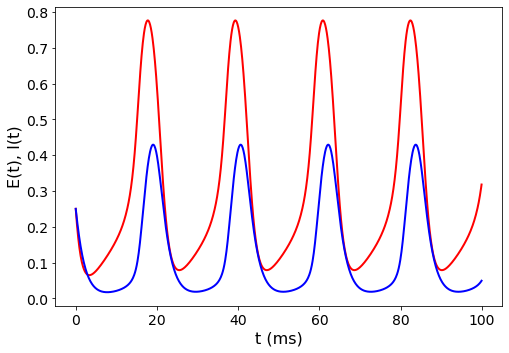

In [17]:
#@title Oscillations
pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['E_init'], pars['I_init'] = 0.25, 0.25

E,I = simulate_wc(pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], E, 'r')
plt.plot(pars['range_t'], I, 'b')
plt.xlabel('t (ms)')
plt.ylabel('E(t), I(t)')
plt.show()

##### Explore: Plot the phase plane

We can also understand the oscillations of the population behavior in the phase plane. By plotting a set of trajectories with different initial states, we can see that these trajectories will go to a circle instead of any fixed points. This circle is called "limit circle", which explains the periodic oscillations of the E and I population behavior.

Try to plot the phase plane with preisously defined functions

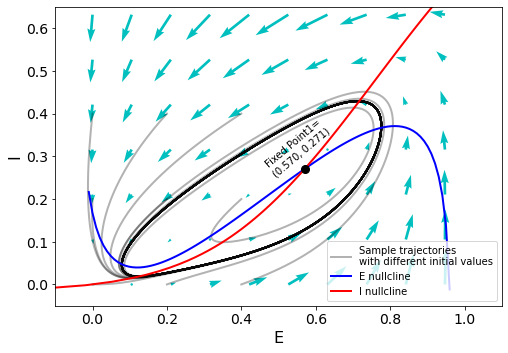

In [18]:
pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8


fig6 = plt.figure(figsize=(8, 5.5))
my_plot_trajectories(pars, 0.2, 3, 'Sample trajectories \nwith different initial values')
my_plot_vector(pars)
my_plot_nullcline(pars)

x_fp_1 = my_fp(pars, 0.8, 0.8)
if check_fp(x_fp_1):
  plt.plot(x_fp_1[0], x_fp_1[1], 'ko')
  plt.text(x_fp_1[0]-0.02, x_fp_1[1]+0.05, 'Fixed Point1=\n(%.3f, %.3f)' \
                %(x_fp_1[0], x_fp_1[1]), horizontalalignment='center', \
                verticalalignment='center', rotation=40)
    
  plt.legend(loc='best', fontsize=10)

  plt.xlim(-0.1, 1.1)
  plt.ylim(-0.05, 0.65)
  plt.show()

#### Parameter Exploration

From the above examples, the change of model parameters changes the shape of the nullclines and accordingly the behavior of the E and I populations from steady fixed points to oscillations. However, the shape of the nullclines is unable to fully determine the behavior of the network. The vector field also matters. To demonstrate this, here we shall the effect of time constants on the population behavior. By changing the inhibitory time constant $\tau_I$, the nullclines do not change, but the network behavior changes substantially from steady state to oscillations with different frequencies. <font size=2, color='gray'>_Critical change is referred as **Hopf bifurcation**._</font>. Please execute the code below to check this out.

In [19]:
#@title Limit Circle Explorer

def time_constant_effect(tau_s, wEI, wIE):
    
    pars = default_pars(T=100.)
    pars['wEE'] = 6.4
    pars['wEI'] = wEI % 4.8
    pars['wIE'] = wIE
    pars['wII'] = 1.2
    pars['I_ext_E'] = 0.8

    pars['tau_I'] = tau_s 
    
    E_grid = np.linspace(0.0,.9,100)
    I_grid = np.linspace(0.0,.6,100)
    
    E_nullcline = get_E_nullcline(pars, E_grid)
    I_nullcline = get_I_nullcline(pars, I_grid)
    
    plt.figure(figsize=(12.5, 5.5))

    plt.subplot(1,2,1) #nullclines
    plt.plot(E_grid, E_nullcline, 'r', label='E nullcline')
    plt.plot(I_nullcline, I_grid, 'b', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    
    #fixed point
    x_fp_1 = my_fp(pars, 0.5, 0.5)
    plt.plot(x_fp_1[0], x_fp_1[1], 'ko')

    eig_1 = get_eig_Jacobian(pars, x_fp_1)
    print('tau_I=%.1f ms,' %tau_s, 'eigenvalue of J matrix ', eig_1)

    #trajectories
    E_tj = np.zeros((pars['range_t'].size, 5, 5))
    I_tj = np.zeros((pars['range_t'].size, 5, 5))
    for ie in range(5):          
        for ii in range(5):
          pars['E_init'], pars['I_init'] = 0.1*ie, 0.1*ii
          E_tj[:, ie, ii], I_tj[:, ie, ii] = simulate_wc(pars)
          plt.plot(E_tj[:, ie, ii], I_tj[:, ie, ii],'k',alpha=0.3)
        
    #vector field
    EI_grid_E = np.linspace(0., 1.0, 20)
    EI_grid_I = np.linspace(0., 0.6, 20)
    E_meshgrid, I_meshgrid = np.meshgrid(EI_grid_E, EI_grid_I)
    dEdt, dIdt = EIderivs(E_meshgrid, I_meshgrid, pars)
    n_skip = 2
    plt.quiver(E_meshgrid[::n_skip,::n_skip], I_meshgrid[::n_skip,::n_skip], 
              dEdt[::n_skip,::n_skip], dIdt[::n_skip,::n_skip], 
              angles='xy', scale_units='xy', scale=10,facecolor='c')
    plt.title(r'$\tau_I=$'+'%.1f ms' % tau_s)

    plt.subplot(1,2,2) # sample E/I trajectories
    pars['E_init'], pars['I_init'] = 0.25, 0.25
    E,I = simulate_wc(pars)
    plt.plot(pars['range_t'], E, 'r')
    plt.plot(pars['range_t'], I, 'b')
    plt.xlabel('t (ms)')
    plt.ylabel('E(t), I(t)')
    plt.title(r'$\tau_I=$'+'%.1f ms' % tau_s)
    plt.tight_layout()
    plt.show()
    
_ = widgets.interact(time_constant_effect,tau_s = (0.1, 3, .1), wEI=(1.,6.,0.1),wIE=(2., 12., .1))

interactive(children=(FloatSlider(value=1.5000000000000002, description='tau_s', max=3.0, min=0.1), FloatSlide…

## Think and try to answer
In the abobve you see the arrangement of the nullclines to generate oscillations. Try to get an intuition about how we can destroy these oscillations -- which connections are most critical to maintain oscillations? 
You can go back to the previous cells to check your intuition.


## <font size=6, color='red'>**Optional:**</font> Fixed point and working memory

The input into the neurons measured in the experiment is often very noisy ([links](http://www.scholarpedia.org/article/Stochastic_dynamical_systems)) . Here, the noisy synaptic input current is modeled as an Ornstein-Uhlenbeck (OU)process, which has been dicussed several times in the previous tutorials.

please excute the following cell of function `my_OU(pars, sig, myseed=False)`

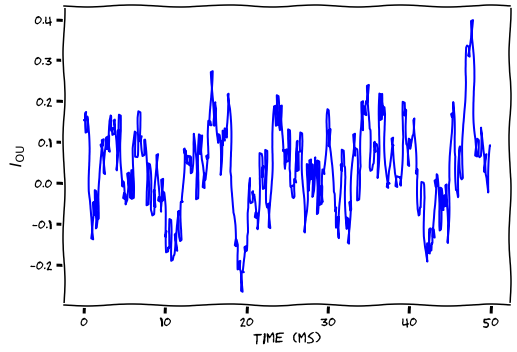

In [ ]:
#@title `my_OU(pars, sig, myseed=False)`
def my_OU(pars, sig, myseed=False):
    '''
    Expects:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean
    
    Returns:
    I          : Ornstein-Uhlenbeck input current
    '''
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou'] # [ms]
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed) 
    else:
        np.random.seed()
        
    # Initialize
    noise =  np.random.randn(Lt)
    I = np.zeros(Lt)
    I[0] = noise[0] * sig
    
    #generate OU
    for it in range(Lt-1):
        I[it+1] = I[it] + dt/tau_ou*(0.-I[it]) + np.sqrt(2.*dt/tau_ou) * sig * noise[it+1]
    
    return I

pars = default_pars(T=50)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=1998)
with plt.xkcd():
    plt.figure(figsize=(8, 5.5))
    plt.plot(pars['range_t'], I_ou, 'b')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$I_{\mathrm{OU}}$')
    plt.show()

With the default parameters, the system fluctuates around a resting state with the noisy input. 

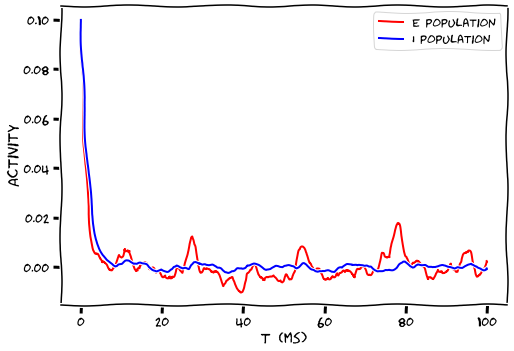

In [ ]:
#@title WC with OU
pars = default_pars(T=100)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)

pars['E_init'], pars['I_init'] = 0.1, 0.1
E,I = simulate_wc(pars)

with plt.xkcd():
    plt.figure(figsize=(8, 5.5))
    ax = plt.subplot(111)
    ax.plot(pars['range_t'], E, 'r', label='E population')
    ax.plot(pars['range_t'], I, 'b', label='I population')
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('Activity')
    ax.legend(loc='best')
    plt.show()


### Short pulse induced persistent activity
Then, let's use a brief 10-ms positive current to the E population when the system at it equilibrium. When this amplitude is sufficiently large, show that a persistent activity is produced that outlasts the transient input. What is the firing rate of the persistent activity and what is the critical input strength? Try to understand the pheomena from the above phase plane analysis

In [ ]:
#@title Pulse Explorer

def my_inject(pars, t_start, t_lag=10.):
    '''
    Expects:
    pars       : parameter dictionary
    t_start    : pulse starts [ms]
    t_lag      : pulse lasts  [ms]
    
    Returns:
    I          : extra pulse time
    '''
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    I = np.zeros(Lt)

    #pulse timing
    N_start = int(t_start/dt)
    N_lag = int(t_lag/dt)
    I[N_start:N_start+N_lag] = 1.

    return I

pars = default_pars(T=100)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)
pars['E_init'], pars['I_init'] = 0.1, 0.1

#pulse
I_pulse = my_inject(pars, t_start=20., t_lag=10.)
L_pulse = sum(I_pulse>0.)

def WC_with_pulse(SE=0.):
  pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
  pars['I_ext_E'] += SE*I_pulse

  E,I = simulate_wc(pars)

  with plt.xkcd():
      plt.figure(figsize=(8, 5.5))
      ax = plt.subplot(111)
      ax.plot(pars['range_t'], E, 'r', label='E population')
      ax.plot(pars['range_t'], I, 'b', label='I population')
      
      ax.plot(pars['range_t'][I_pulse>0.], 1.0*np.ones(L_pulse), 'r', lw=2.)
      ax.text(25, 1.05, 'stimulus on', horizontalalignment='center', 
              verticalalignment='bottom')
      ax.set_ylim(-0.03, 1.2)
      ax.set_xlabel('t (ms)')
      ax.set_ylabel('Activity')
      ax.legend(loc='best')
      plt.show()

_ = widgets.interact(WC_with_pulse, SE = (0.45, 0.5, .01))

interactive(children=(FloatSlider(value=0.45, description='SE', max=0.5, min=0.45, step=0.01), Output()), _dom…

Explore the phenomena that the persistent activity can be switched off with a second brief current into the inhibitory population. 